In [1]:
!pip install gdown
!gdown --id "1EerxeopxXaRF0seUZwtsP1WqKUD0I0vp" -O dog_images.zip
!unzip -q dog_images.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EerxeopxXaRF0seUZwtsP1WqKUD0I0vp
From (redirected): https://drive.google.com/uc?id=1EerxeopxXaRF0seUZwtsP1WqKUD0I0vp&confirm=t&uuid=a0fccfb6-eb8d-46a4-8c53-496ae6810326
To: /content/dog_images.zip
100% 787M/787M [00:05<00:00, 156MB/s]


TODO:
- Double check class_mapping.json
- Add references to README
- Create confusion matrix
- Report per class accuracy (potentially top k accuracy as well)
- Run on custom input
- Potentially table of images with real vs predicted labels

In [2]:
# Import the necessary libraries
import os
import json
import timm
import torch
import shutil
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from contextlib import nullcontext
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm.data import resolve_model_data_config
from sklearn.model_selection import train_test_split

In [3]:
# Set the random seeds for reproducibility
SEED = 27
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
# Initialize the data paths
ORIGINAL_DATA_PATH = "data/raw/images"
SPLIT_DATA_PATH = "data/processed"

# Initialize the split ratios and number of classes
VALID_SIZE = 0.15
TEST_SIZE = 0.15
NUM_CLASSES = 120

# Initialize the data pipeline hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 2

In [5]:
# Returns True if the file at the specified path is an uncorrupted image, False otherwise
def is_image(path):
    try:
        Image.open(path).verify()
        return True
    except Exception as e:
        return False

# Performs a stratified split of the data into training, validation, and test sets
def split_data(input_path, output_path, valid_size=VALID_SIZE, test_size=TEST_SIZE):
    # Remove any existing data split directories
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    # Create the train, valid, and test directories
    for dir in ["train", "valid", "test"]:
        os.makedirs(os.path.join(output_path, dir), exist_ok=True)

    # Iterate through each dog breed directory
    breed_dirs = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]
    for breed in breed_dirs:
        # Get all the image names for the current breed
        breed_path = os.path.join(input_path, breed)
        images = [f for f in os.listdir(breed_path) if is_image(os.path.join(breed_path, f))]

        # Split the images into (train + validation) and test sets
        train_valid_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=27)

        # Further split the (train + validation) image set into train and validation sets
        train_imgs, valid_imgs = train_test_split(train_valid_imgs, test_size=valid_size/(1-test_size), random_state=27)

        # Copy the images into their appropriate locations
        for set, img_list in zip(['train', 'valid', 'test'], [train_imgs, valid_imgs, test_imgs]):
            set_breed_path = os.path.join(output_path, set, breed)
            os.makedirs(set_breed_path, exist_ok=True)
            for img in img_list:
                shutil.copy(os.path.join(breed_path, img), os.path.join(set_breed_path, img))

# Split the data into training, validation, and test sets
split_data(ORIGINAL_DATA_PATH, SPLIT_DATA_PATH, VALID_SIZE, TEST_SIZE)

In [6]:
# Load the EfficientNet-B3 model, pretrained on ImageNet-1K, and replace its head
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)

# Retrieve the model configurations to ensure that inputs will adhere to them
data_config = resolve_model_data_config(model)
img_size = data_config["input_size"][-1]
mean = data_config["mean"]
std = data_config["std"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [7]:
# Returns datasets and data loaders, including transformations, for training, validation, and testing
def get_dataloaders(data_dir, img_size=img_size, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Create data transformations for training and validation/testing
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.02
        ),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize(int(img_size * 1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    # Create datasets for training, validation, and testing
    image_datasets = {
        "train":datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transforms),
        "valid":datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=valid_test_transforms),
        "test":datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=valid_test_transforms)
    }

    # Create data loaders for training, validation, and testing
    data_loaders = {
        "train":DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
        "valid":DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
        "test":DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    }

    # Return the datasets and data loaders
    return image_datasets, data_loaders

# Initialize the datasets and data loaders
image_datasets, data_loaders = get_dataloaders(SPLIT_DATA_PATH, img_size, BATCH_SIZE, NUM_WORKERS)

In [8]:
# Determine which device to use (GPU if available, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Determine whether to use automatic mixed precision (AMP) based on the device
use_amp = device.type in {"cuda", "mps"}

# Move the model to the selected device
model.to(device)

# Output the device being used
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Returns a list of the model's head parameters
def get_head_params(model):
    return list(model.get_classifier().parameters())

# Returns a list of the model's backbone parameters
def get_backbone_params(model):
    head_ids = {id(p) for p in get_head_params(model)}
    return [p for p in model.parameters() if id(p) not in head_ids]

# Freezes all the model's parameters
def freeze_all(model):
    for p in model.parameters():
        p.requires_grad = False

# Unfreezes only the model's head parameters
def unfreeze_head_only(model):
    freeze_all(model)
    for p in get_head_params(model):
        p.requires_grad = True

# Unfreezes all the model's parameters
def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

# Returns the appropriate autocast context manager based on the device and AMP usage
def autocast_ctx(device=device, use_amp=use_amp):
    if not use_amp:
        return nullcontext()
    if device.type == "cuda":
        return torch.amp.autocast("cuda", dtype=torch.float16)
    if device.type == "mps":
        return torch.amp.autocast("mps", dtype=torch.float16)
    return nullcontext()

# Trains the model for one epoch
def train_one_epoch(model, dataloader, device, use_amp, criterion, optimizer, scaler=None):
    # Switch the model into training mode
    model.train()

    # Initialize running loss and accuracy metric variables
    running_loss = 0.0
    correct = 0
    total = 0

    # Load the data in batches
    for inputs, labels in dataloader:
        # Move the images and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Reset the optimizer's gradients
        optimizer.zero_grad(set_to_none=True)

        # If using AMP, perform the forward and backward passes with mixed precision
        if scaler is not None and use_amp:
            with autocast_ctx(device, use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Otherwise, perform the forward and backward passes normally
        else:
            with autocast_ctx(device, use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Update the running loss and accuracy metrics
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Return the average loss and accuracy for the epoch
    return running_loss / total, correct / total

# Evaluates the model on a validation or test dataset, returning the loss and accuracy
def evaluate(model, dataloader, device, use_amp,criterion):
    # Switch the model into evaluation mode
    model.eval()

    # Initialize running loss and accuracy metric variables
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Load the data in batches
        for inputs, labels in dataloader:
            # Move the images and labels to the selected device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # With the necessary autocast context, perform the forward pass
            with autocast_ctx(device, use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Update the running loss and accuracy metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Return the average loss and accuracy for the current model and dataset
    return running_loss / total, correct / total


# Runs a training phase for a specified number of epochs, with optional early stopping
def run_training_phase(phase_name, start_epoch, num_epochs, model, train_loader, val_loader, device, use_amp, criterion,
                       optimizer, scheduler, scaler, best_val_acc, history, ckpt_path, early_stopping_patience=None):
    # Initialize variables for tracking the current epoch and early stopping
    epoch = start_epoch
    no_improve = 0

    # Train the model for the specified number of epochs
    for i in range(num_epochs):
        # Train the model for one epoch, recording the training loss and accuracy
        train_loss, train_acc = train_one_epoch(model, train_loader, device, use_amp, criterion, optimizer, scaler)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)

        # Evaluate the model on the validation dataset, recording the validation loss and accuracy
        val_loss, val_acc = evaluate(model, val_loader, device, use_amp, criterion)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Update the learning rate scheduler, if one is provided
        if scheduler is not None:
            scheduler.step()

        # If the current validation accuracy is the best so far, save the model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            ckpt_dir = os.path.dirname(ckpt_path)
            if ckpt_dir:
                os.makedirs(ckpt_dir, exist_ok=True)
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_acc": val_acc,
                },
                ckpt_path,
            )
            no_improve = 0

        # Otherwise, increment the no improvement counter for early stopping, if applicable
        else:
            if early_stopping_patience is not None:
                no_improve += 1
                # If the early stopping threshold has been met, stop training
                if no_improve >= early_stopping_patience:
                    print(f"[{phase_name}] Early stopping at epoch {epoch} after {no_improve} epochs without improvement.")
                    print(f"\tBest Validation Accuracy: {best_val_acc:.3f}")
                    print(f"\tCheckpoint saved to {ckpt_path}")
                    break

        # Output the training and validation metrics for the current epoch
        print(
            f"[{phase_name} {i+1}/{num_epochs} | Epoch {epoch}] "
            f"train_loss={train_loss:.3f} train_acc={train_acc:.3f} "
            f"val_loss={val_loss:.3f} val_acc={val_acc:.3f} "
            f"(best_val_acc={best_val_acc:.3f})"
        )

        # Increment the epoch counter
        epoch += 1

    # Return the best validation accuracy and the epoch at which training concluded
    return best_val_acc, epoch

In [14]:
# Define the training hyperparameters and model checkpoint path
P1_EPOCHS = 10
P2_EPOCHS = 15
PATIENCE = 4
BEST_MODEL_PATH = "models/best_model.pth"
FINAL_MODEL_PATH = "models/final_model.pth"

# Define the loss criterion and AMP scaler
criterion = nn.CrossEntropyLoss()
scaler = None if not use_amp else torch.amp.GradScaler(device.type)

# Initialize variables to track the best validation accuracy, current epoch, and training history
best_val_acc = 0
current_epoch = 0
history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

In [11]:
# ---- Phase 1: Train the model's head only ----
# Unfreeze only the model's head
unfreeze_head_only(model)

# Create the optimizer and learning rate scheduler for phase 1
optimizer_p1 = torch.optim.AdamW(get_head_params(model), lr=1e-3, weight_decay=1e-4)
scheduler_p1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_p1, T_max=P1_EPOCHS)

# Run the training phase for Phase 1: Warmup
best_val_acc, current_epoch = run_training_phase("Warmup", current_epoch, P1_EPOCHS, model, data_loaders["train"], data_loaders["valid"],
                                                 device, use_amp, criterion, optimizer_p1, scheduler_p1, scaler, best_val_acc, history,
                                                 BEST_MODEL_PATH, PATIENCE)

[Warmup 1/10 | Epoch 0] train_loss=2.201 train_acc=0.542 val_loss=1.085 val_acc=0.754 (best_val_acc=0.754)
[Warmup 2/10 | Epoch 1] train_loss=0.954 train_acc=0.764 val_loss=0.852 val_acc=0.777 (best_val_acc=0.777)
[Warmup 3/10 | Epoch 2] train_loss=0.749 train_acc=0.810 val_loss=0.728 val_acc=0.796 (best_val_acc=0.796)
[Warmup 4/10 | Epoch 3] train_loss=0.630 train_acc=0.835 val_loss=0.991 val_acc=0.781 (best_val_acc=0.796)
[Warmup 5/10 | Epoch 4] train_loss=0.552 train_acc=0.858 val_loss=0.683 val_acc=0.799 (best_val_acc=0.799)
[Warmup 6/10 | Epoch 5] train_loss=0.497 train_acc=0.872 val_loss=0.711 val_acc=0.794 (best_val_acc=0.799)
[Warmup 7/10 | Epoch 6] train_loss=0.461 train_acc=0.886 val_loss=0.679 val_acc=0.805 (best_val_acc=0.805)
[Warmup 8/10 | Epoch 7] train_loss=0.439 train_acc=0.888 val_loss=0.681 val_acc=0.808 (best_val_acc=0.808)
[Warmup 9/10 | Epoch 8] train_loss=0.421 train_acc=0.901 val_loss=0.597 val_acc=0.828 (best_val_acc=0.828)
[Warmup 10/10 | Epoch 9] train_loss=0

In [12]:
# ---- Phase 2: Train the entire model ----
# Unfreeze all the model's layers
unfreeze_all(model)

# Create the optimizer and learning rate scheduler for phase 2
optimizer_p2 = torch.optim.AdamW(
        [
            {"params": get_backbone_params(model), "lr": 1e-4},
            {"params": get_head_params(model), "lr": 5e-4},
        ],
        weight_decay=1e-4,
    )
scheduler_p2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_p2, T_max=P2_EPOCHS)

# Run the training phase for Phase 2: Fine-tuning
best_val_acc, current_epoch = run_training_phase("Fine-tuning", current_epoch, P2_EPOCHS, model, data_loaders["train"], data_loaders["valid"],
                                                 device, use_amp, criterion, optimizer_p2, scheduler_p2, scaler, best_val_acc, history,
                                                 BEST_MODEL_PATH, PATIENCE)

# Save the final model

torch.save(model.state_dict(), "models/final_model.pth")
print(f"Final checkpoint saved to {FINAL_MODEL_PATH}")

[Fine-tuning 1/15 | Epoch 10] train_loss=0.316 train_acc=0.905 val_loss=0.432 val_acc=0.860 (best_val_acc=0.860)
[Fine-tuning 2/15 | Epoch 11] train_loss=0.151 train_acc=0.955 val_loss=0.468 val_acc=0.868 (best_val_acc=0.868)
[Fine-tuning 3/15 | Epoch 12] train_loss=0.094 train_acc=0.974 val_loss=nan val_acc=0.868 (best_val_acc=0.868)
[Fine-tuning 4/15 | Epoch 13] train_loss=0.059 train_acc=0.987 val_loss=0.494 val_acc=0.875 (best_val_acc=0.875)
[Fine-tuning 5/15 | Epoch 14] train_loss=0.044 train_acc=0.990 val_loss=nan val_acc=0.878 (best_val_acc=0.878)
[Fine-tuning 6/15 | Epoch 15] train_loss=0.036 train_acc=0.991 val_loss=0.447 val_acc=0.876 (best_val_acc=0.878)
[Fine-tuning 7/15 | Epoch 16] train_loss=0.029 train_acc=0.993 val_loss=1.599 val_acc=0.876 (best_val_acc=0.878)
[Fine-tuning 8/15 | Epoch 17] train_loss=0.023 train_acc=0.995 val_loss=0.473 val_acc=0.874 (best_val_acc=0.878)
[Fine-tuning 9/15 | Epoch 18] train_loss=0.021 train_acc=0.995 val_loss=0.445 val_acc=0.879 (best_va

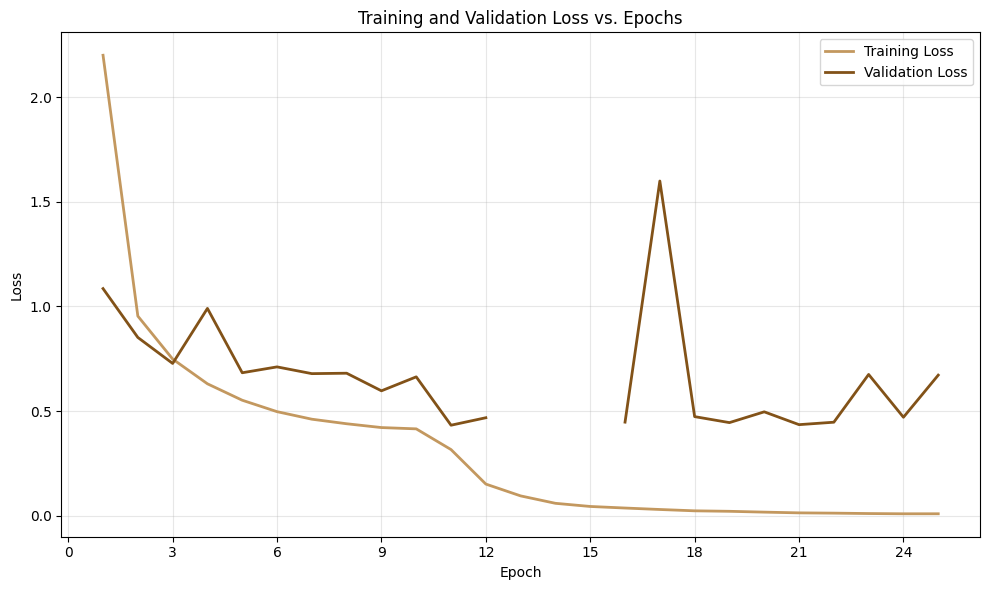

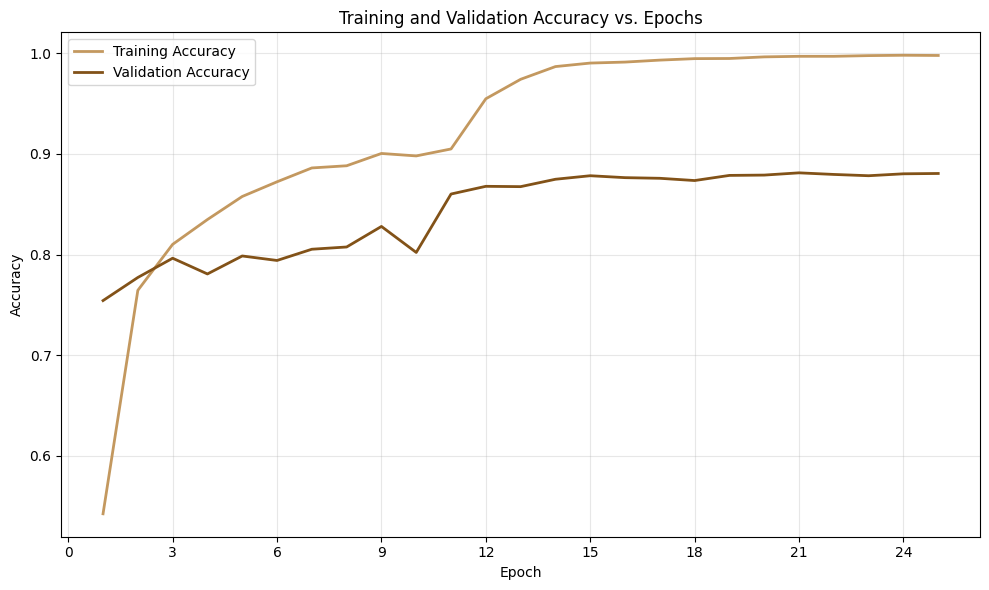

In [13]:
# Plots the training and validation curves for a given metric (Loss or Accuracy)
def plot_training_metric(history, metric="Loss"):
    values_train = history[f"train_{metric.lower()}"]
    values_val = history[f"val_{metric.lower()}"]
    epochs = range(1, len(values_train) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values_train, label=f"Training {metric}", linewidth=2, color="#C3985F")
    plt.plot(epochs, values_val, label=f"Validation {metric}", linewidth=2, color="#825218")

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Training and Validation {metric} vs. Epochs")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the training and validation loss and accuracy curves
plot_training_metric(history, "Loss")
plot_training_metric(history, "Accuracy")

In [15]:
# Load the best model
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# Evaluate the model on both the validation and test datasets, reporting their losses and accuracies
val_loss, val_acc = evaluate(model, data_loaders["valid"], device, use_amp, criterion)
test_loss, test_acc = evaluate(model, data_loaders["test"], device, use_amp, criterion)
print(f"Final Validation Loss: {val_loss:.3f}, Final Validation Accuracy: {val_acc:.3f}")
print(f"Final Test Loss: {test_loss:.3f}, Final Test Accuracy: {test_acc:.3f}")

Final Validation Loss: 0.435, Final Validation Accuracy: 0.881
Final Test Loss: 0.409, Final Test Accuracy: 0.882
